# Solve the GridWorld problems with goals.

Consider a MazeWorld problems. 

Assume we have a series of tasks. Every task share the same $H \times W$ maze, but has a different goal. <br>
The goal is to navigate and collect a bean. 

The agent knows aprior the shape of the maze, as well as the location of the bean encoded as a $H \times W$ 0-1 matrix.

**Question**

1. Is it possible for the agent to learn a shared Q network for different tasks?
    > YES
    
    * note: 
    
    **It is better to have the training tasks interleave. i.e. one task show up for training for only a small number of episodes**



2. Is it possible to learn Q network on subset of the tasks, and generalize to others?

    * Idea 1. Set goals only at even locations, i.e.
    $$G[2 i, 2 j] = 1$$ for some $i$ and $j$.
    And test at tasks with other locations


## Imported Libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import scriptinit
from scriptutils import *
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import matplotlib
import pylab as plt
import time
import pdb
from IPython import display
from gridworld import Grid, GridWorldMDP, GridWorld, GridWorldWithGoals
from agent import ValueIterationSolver, TDLearner, DQN, RecurrentReinforceAgent

## Reused Methods

In [5]:
# diagnostic function
def compute_value_function(goal, rewards, total_reward):
    global GT
    global grid
    values = np.zeros(world.shape)
    dqn.task.reset(goal, rewards)
    for row in xrange(world.shape[0]):
        for col in xrange(world.shape[1]):
            if world[row, col] == 0:  # agent can occupy this state
                agent_state = np.zeros_like(world)
                agent_state[row, col] = 1.
                state_resized = agent_state.ravel().reshape(-1, 1)
                goal_resized = goal.reshape(-1, 1)
                state = np.concatenate((state_resized, goal_resized), axis=0)
                qvals = dqn.fprop(state.T)
                values[row, col] = np.max(qvals)
    
    for pos, r in rewards.items():
        values[pos] = r

    print 'values', values, '\n'
    
    print 'goal', dqn.task.goal, '\n'
    
#     GT = solve_by_value_iteration(grid, rewards)
#     error = npla.norm(values - GT, 'fro')
#     return error

In [6]:
# template for interaction between the agent and the task
def grid_experiment(agent, grid_task, goal_rewards_pairs, num_episodes, num_episode_in_task, diagnostic_callback=None, switch_task_frequency=100, diagnostic_frequency=100):
    episodes = []
    errors = []
    (goal, rewards) = goal_rewards_pairs[0]
    for episode in xrange(num_episodes):
        total_reward = 0.
        while grid_task.is_terminal():
            ind = npr.choice(len(goal_rewards_pairs), 1)
            if episode % num_episode_in_task == 0:
                (goal, rewards) = goal_rewards_pairs[ind]
            grid_task.reset(goal, rewards)

        curr_state = grid_task.get_current_state()
        num_steps = 0.
        while True:
            num_steps += 1
            if num_steps > 200:
                print 'Lying and tell the agent the episode is over!'
                agent.end_episode(0)
                num_steps = 0.
            action = agent.get_action(curr_state)
            next_state, reward = grid_task.perform_action(action)
#             print 'state', grid_task.env.state_pos[grid_task.env.get_current_state()]
            total_reward += reward
            if grid_task.is_terminal():
                agent.end_episode(reward)
                break
            else:
                agent.learn(next_state, reward)
                curr_state = next_state
        
        if episode % diagnostic_frequency == 0:
            if diagnostic_callback is not None:
                print 'episode number: ',  episode
                error = diagnostic_callback(goal, rewards, total_reward)
                episodes.append(episode)
                errors.append(error)
                
    # plot convergence curve.
#     if errors:
#         plt.cla()
#         plt.plot(episodes, errors)
        # display.clear_output(wait=True)
#         display.display(plt.gcf())
#         plt.close()

## Training

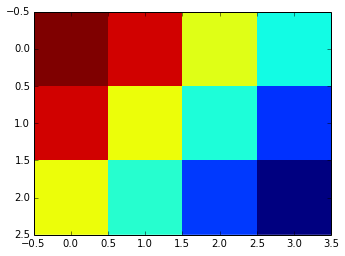

In [14]:
# set up the environment.
H = 3
W = 4
world = np.zeros((H, W))

goal_rewards_pairs = []
for ni in range(0, H, 2):
    for nj in range(0, W, 2):
        goal = np.zeros((H, W))
        goal[ni, nj] = 1.
        rewards = {(ni, nj): 1.}
        goal_rewards_pairs.append((goal, rewards))
(base_goal, base_rewards) = goal_rewards_pairs[0]
task = GridWorldWithGoals(grid, base_goal, base_rewards, wall_penalty=0., gamma=0.9)
_ = plt.imshow(solve_world_by_value_iteration(world, base_rewards), interpolation='none')


## Training 

** Use 2 hidden layers, each with 128 dimension**

In [27]:
# deep Q learning.
dqn = DQN(task, hidden_dim=128, l2_reg=0.0, lr=0.05, epsilon=0.15)

Compiling fprop
Compiling backprop
done


In [28]:
grid_experiment(dqn, task, goal_rewards_pairs, num_episodes=50001, num_episode_in_task=11, diagnostic_callback=compute_value_function, diagnostic_frequency=1000)

Lying and tell the agent the episode is over!
episode number:  0
values [[ 1.          0.39503204  0.41770889  0.43323954]
 [ 0.62324082  0.409072    0.35109647  0.37036856]
 [ 0.44396185  0.42783675  0.37060292  0.41106561]] 

goal [[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]] 

episode number:  1000
values [[ 0.7793838   0.75884418  0.84264804  0.70927523]
 [ 0.73775788  0.87430068  0.89976754  0.84525264]
 [ 0.84475463  0.95881654  1.          0.90548252]] 

goal [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]] 

episode number:  2000
values [[ 1.          0.9378785   0.81707946  0.72770295]
 [ 1.03033269  0.9012481   0.78863645  0.6831857 ]
 [ 0.89155016  0.74360622  0.66712954  0.59576336]] 

goal [[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]] 

episode number:  3000
values [[ 1.          0.97586961  0.87658087  0.76384106]
 [ 0.95333487  0.87633166  0.71075993  0.64713874]
 [ 0.78846159  0.77658813  0.69440406  0.60955361]] 

goal [[ 1.  0.  0.  0.

/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


## Test the learned Q network  aginst ground truth.

**on training set**

In [32]:
goal = np.zeros((H, W))
goal[2, 2] = 1
rewards = {(2,2): 1}
compute_value_function(goal, rewards, None)
_ = solve_by_value_iteration(grid, rewards)

values [[ 0.67949661  0.77204059  0.83103233  0.79131052]
 [ 0.72368814  0.88753414  0.98677481  0.88524093]
 [ 0.8593017   0.97000265  1.          0.9832392 ]] 

goal [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]] 

ground truth [[ 0.67282207  0.75552356  0.84508353  0.76824471]
 [ 0.75590759  0.85388134  0.96534012  0.86414893]
 [ 0.85323349  0.97049232  1.          0.97679857]] 



In [35]:
goal = np.zeros((H, W))
goal[0, 0] = 1
rewards = {(0,0): 1}
compute_value_function(goal, rewards, None)
_ = solve_by_value_iteration(grid, rewards)

values [[ 1.          0.98058428  0.84217933  0.74199983]
 [ 0.97823695  0.86778606  0.75809714  0.67054705]
 [ 0.82504406  0.74715409  0.66159337  0.61395757]] 

goal [[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]] 

ground truth [[ 1.          0.97023492  0.84774168  0.74555131]
 [ 0.97049335  0.85391016  0.75141657  0.66509466]
 [ 0.85322621  0.75574253  0.66883632  0.59515284]] 



**on test set**

In [36]:
goal = np.zeros((H, W))
goal[1, 3] = 1
rewards = {(1,3): 1}
compute_value_function(goal, rewards, None)
_ = solve_by_value_iteration(grid, rewards)

values [[ 0.84064441  0.84124972  0.77905923  0.81954755]
 [ 0.75384143  0.75960191  0.73671204  1.        ]
 [ 0.64726839  0.70468863  0.77843751  0.7130822 ]] 

goal [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]] 

ground truth [[ 0.67840874  0.76362697  0.86393412  0.97678795]
 [ 0.73727178  0.84057222  0.96557982  1.        ]
 [ 0.67840864  0.76362696  0.86393412  0.97678795]] 



In [37]:
goal = np.zeros((H, W))
goal[1, 1] = 1
rewards = {(1, 1): 1}
compute_value_function(goal, rewards, None)
_ = solve_by_value_iteration(grid, rewards)

values [[ 0.78879935  0.85324834  0.7374074   0.84768598]
 [ 0.76705193  1.          0.8417424   0.77183193]
 [ 0.71568966  0.91557017  0.80940718  0.86574871]] 

goal [[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]] 

ground truth [[ 0.86477371  0.97130416  0.85956992  0.76440962]
 [ 0.97154936  1.          0.96540303  0.84537192]
 [ 0.86477358  0.97130414  0.85956989  0.76440956]] 



## Conclusion

* Using *"interleaving"*, the agent could learn much better on training tasks. 
* this kind of contradicts what John has discovered, i.e. training for long time on a single task is better.
* On test tasks, the value function is not accurate. but it seems the agent is able to capture *relative importance* 